# Exploring Raw Datasets

In this workbook we explore the hourly datasets collected, both to give understanding and to search for any anomalous or missing data.

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import numpy as np
import math
from helper_functions import *
from datetime import date, timedelta
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop


#Importing the datasets
current_folder = os.path.abspath('')

bitcoin_csv = os.path.join(current_folder, "data","bitcoin_hourly.csv")
ethereum_csv = os.path.join(current_folder, "data","ethereum_hourly.csv")
dogecoin_csv = os.path.join(current_folder, "data","dogecoin_hourly.csv")

bitcoin_df = pd.read_csv(bitcoin_csv)
ethereum_df = pd.read_csv(ethereum_csv)
dogecoin_df = pd.read_csv(dogecoin_csv)

We are adding a feature which is the difference between the high and low prices each hour and removing the open price, marketcap, high and low prices due to their similarity to the close price when plotted. 

open price and marketcap will likely not be used in models. High and low may be used, but the differnce should give better indication if there's any anomalous spikes in the data.

The difference between high and low should give some indication of the volatility in that hour. It should also be easier to distinguish from the close price.

In [15]:
bitcoin_df['highLowDif'] = bitcoin_df['highPriceUsd'] - bitcoin_df['lowPriceUsd']
ethereum_df['highLowDif'] = ethereum_df['highPriceUsd'] - ethereum_df['lowPriceUsd']
dogecoin_df['highLowDif'] = dogecoin_df['highPriceUsd'] - dogecoin_df['lowPriceUsd']

# removing features we do not wish to plot, or that will not be used in predictions
bitcoin_df = bitcoin_df.drop(columns=['openPriceUsd', 'highPriceUsd', 'lowPriceUsd', 'marketcap'])
ethereum_df = ethereum_df.drop(columns=['openPriceUsd', 'highPriceUsd', 'lowPriceUsd', 'marketcap'])
dogecoin_df = dogecoin_df.drop(columns=['openPriceUsd', 'highPriceUsd', 'lowPriceUsd', 'marketcap'])

In [16]:
print(bitcoin_df.iloc[0])
print(ethereum_df.iloc[0])
print(dogecoin_df.iloc[0])

datetime                      2021-02-03 00:00:00+00:00
bitcoin_count                                      1557
bitcoin_polarity                               0.198884
bitcoin_subjectivity                           0.503805
bitcoin_polarity_zeros                         0.105064
bitcoin_subjectivity_zeros                     0.303084
closePriceUsd                              36119.489863
volume                                    62260118369.0
highLowDif                                   687.926195
Name: 0, dtype: object
datetime                       2021-02-03 00:00:00+00:00
ethereum_count                                       508
ethereum_polarity                               0.172375
ethereum_subjectivity                           0.489083
ethereum_polarity_zeros                         0.098114
ethereum_subjectivity_zeros                     0.321798
closePriceUsd                                1520.243924
volume                                     44437743410.0
highLowDif       

## Defining methods to plot and explore data

These functions also exist in the `helper_functions.py` file

In [17]:
def plot_timeseries_features(dataframe, feature_names, time_column, feature_titles=False):
    time_data = dataframe[time_column]
    fig = plt.figure(figsize=(12, 20))
    columns = 2
    rows = math.ceil(len(feature_names)/2)

    # reference https://stackoverflow.com/questions/53521396/how-to-implement-automatic-color-change-in-matplotlib-with-subplots
    colours = plt.rcParams["axes.prop_cycle"]()

    for i in range(0, len(feature_names)):
        c = next(colours)["color"]
        ax = fig.add_subplot(rows, columns, i+1)
        col_data = dataframe[feature_names[i]]
        col_data.index = time_data
        col_data.head()
        if feature_titles:
            ax = col_data.plot(c=c, rot=25, title=feature_titles[i])
        else:
            ax = col_data.plot(c=c, rot=25)
        ax.legend([feature_names[i]])
    plt.tight_layout()
    plt.show()


def print_largest_each_column(dataframe, column_names, number_largest):
    print('-' * 80)
    for i in range(0, len(column_names)):
        top = dataframe[column_names[i]].nlargest(number_largest)
        print(column_names[i])
        print(top)
        print('-' * 80)


def rows_with_nan_values(dataframe):
    # https://www.kite.com/python/answers/how-to-find-the-indices-of-rows-in-a-pandas-dataframe-containing-nan-values-in-python
    rows_with_nan = []
    for index, row in dataframe.iterrows():
        nan_indexes = row.isnull()
        if nan_indexes.any():
            rows_with_nan.append(index)
    return rows_with_nan


def plot_heatmap(dataframe, coin_name, column_names):

    # Adapted from: https://keras.io/examples/timeseries/timeseries_weather_forecasting/
    cor = dataframe.corr()
    plt.figure(figsize=(10, 10))
    plt.matshow(cor, fignum=1)
    plt.xticks(np.arange(len(column_names)),
               column_names, rotation=90, fontsize=16)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(np.arange(len(column_names)), column_names, fontsize=16)
    cb = plt.colorbar()
    plt.title(coin_name + " Feature Correlation Heatmap", fontsize=20)

    plt.show()


## Readying Data for plotting and inspection

In [18]:
# Creating lists of variable names for each dataset
bitcoin_column_names = list(bitcoin_df.columns.values.tolist())
ethereum_column_names = list(ethereum_df.columns.values.tolist())
dogecoin_column_names = list(dogecoin_df.columns.values.tolist())

time_column = 'datetime'
# removing the time column from column names (so it is not plotted by itself)
bitcoin_column_names.remove(time_column)
ethereum_column_names.remove(time_column)
dogecoin_column_names.remove(time_column)

# Setting the plot titles for each cryptocurrency (optional)
titles = ['tweet count', 'polarity without zeros', 'subjectivity without zeros', 'polarity with zeros', 'subjectivity with zeros', 'close price', 'volume', 'difference high low']

bitcoin_titles = []
ethereum_titles = []
dogecoin_titles = []

for title in titles:
    bitcoin_title = 'Bitcoin ' + title
    ethereum_title = 'Ethereum ' + title
    dogecoin_title = 'Dogecoin ' + title
    bitcoin_titles.append(bitcoin_title)
    ethereum_titles.append(ethereum_title)
    dogecoin_titles.append(dogecoin_title)

# removing UTC from dates to make them easier to print below plots
bitcoin_df[time_column] = pd.to_datetime(bitcoin_df[time_column], errors='coerce', utc=False)
ethereum_df[time_column] = pd.to_datetime(ethereum_df[time_column], errors='coerce', utc=False)
dogecoin_df[time_column] = pd.to_datetime(dogecoin_df[time_column], errors='coerce', utc=False)

# converting to strings format 'DD-MM-YYYY hr:00'
bitcoin_df[time_column] = bitcoin_df[time_column].dt.strftime('%d-%m-%Y %H:00')
ethereum_df[time_column] = ethereum_df[time_column].dt.strftime('%d-%m-%Y %H:00')
dogecoin_df[time_column] = dogecoin_df[time_column].dt.strftime('%d-%m-%Y %H:00')

## Inspecting Bitcoin Data


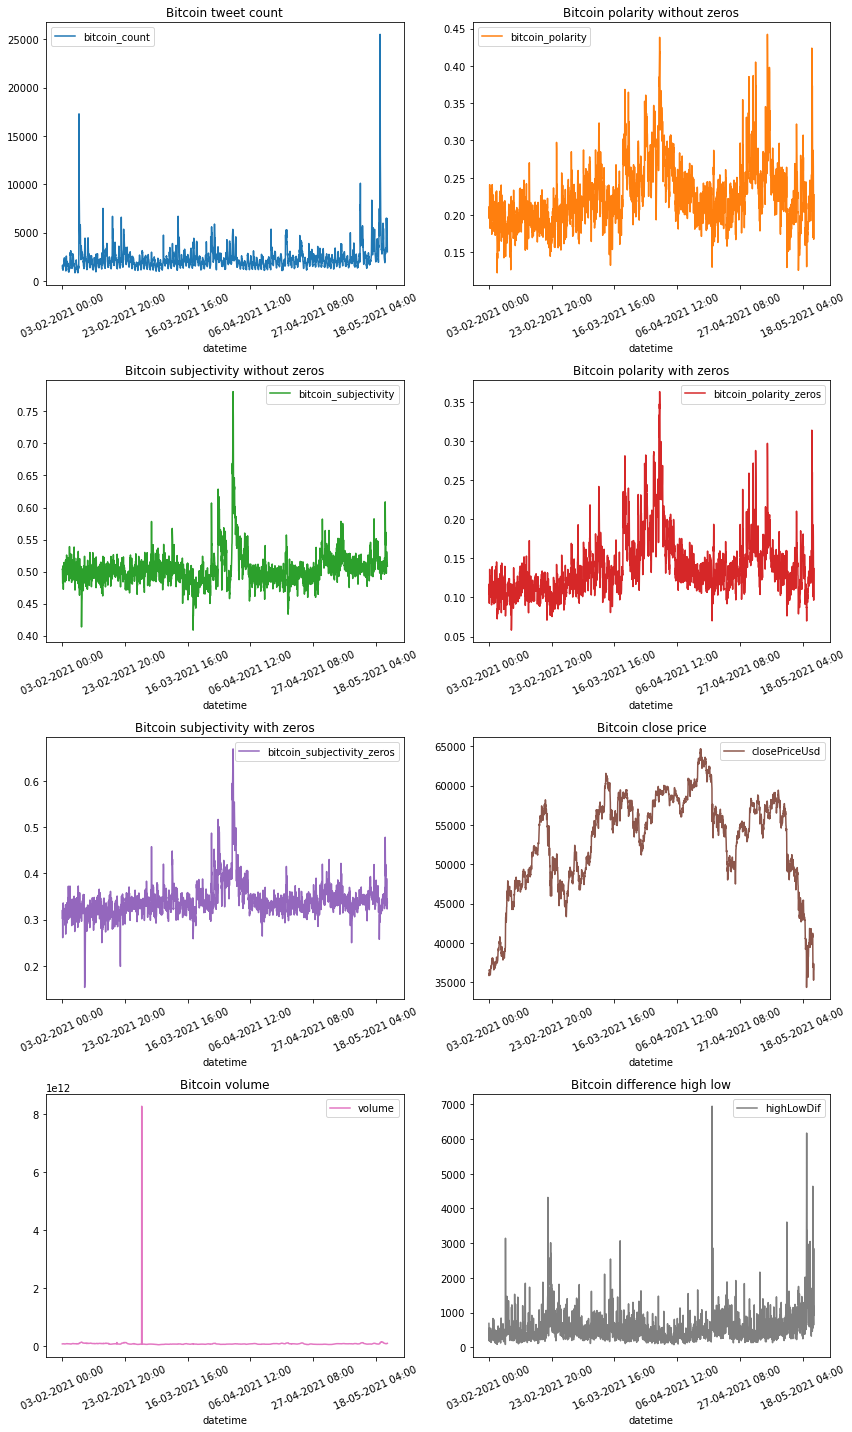

In [19]:
plot_timeseries_features(bitcoin_df, bitcoin_column_names, time_column, bitcoin_titles)

Anomalous spike in bitcoin volume at `2021-03-01 09:00:00+00:00`. value is `8266595373109` when values before and after are `51381755594` and `53029960114`.

There is also a possible spike in the difference between high and low values, however this could be a normal spike.

I will average the value before and after the anomalous spike in bitcoin volume and replace the value.

In [20]:
new_val = (51381755594+53029960114)/2
print(new_val)

52205857854.0


### Printing highest values in each column

To identify any possible anomalous values.

In [21]:
print_largest_each_column(bitcoin_df, bitcoin_column_names, 10)

--------------------------------------------------------------------------------
bitcoin_count
datetime
19-05-2021 13:00    25513
08-02-2021 13:00    17288
19-05-2021 14:00    16723
19-05-2021 15:00    12977
19-05-2021 12:00    12552
08-02-2021 14:00    11032
19-05-2021 16:00    10688
13-05-2021 00:00    10116
19-05-2021 17:00     9007
08-02-2021 15:00     8613
Name: bitcoin_count, dtype: int64
--------------------------------------------------------------------------------
bitcoin_polarity
datetime
06-05-2021 12:00    0.442287
31-03-2021 17:00    0.438291
21-05-2021 06:00    0.423756
31-03-2021 19:00    0.418835
31-03-2021 18:00    0.417060
31-03-2021 16:00    0.416430
06-05-2021 13:00    0.414947
31-03-2021 15:00    0.410821
02-05-2021 14:00    0.405055
07-05-2021 04:00    0.397939
Name: bitcoin_polarity, dtype: float64
--------------------------------------------------------------------------------
bitcoin_subjectivity
datetime
31-03-2021 17:00    0.780911
31-03-2021 18:00    0.7505

As identified from the plots, the only anomalous value seems to be the spike in trade volume, with the value being over 10x the next highest. Only it will be removed.

### Detecting any missing values

Although care was taken not exclude any hours of price data with no data at all, there may be individual columns with missing entries. The below function returns an array of any rows containing missing or 'not a number' values.

In [22]:
print(rows_with_nan_values(bitcoin_df))

[1044, 1045]


Missing values identified in rows 1044 and 1045. On inspection these are both trade volume values. There are two missing values, but again they will be replaced with the average of the values before and after them.

In [34]:
new_val = (58625896778+56735309311)/2
print(new_val)

57680603044.5


### Feature heatmap

We will run these again in another workbook once the anomalous data has been replaced and missing data filled in.

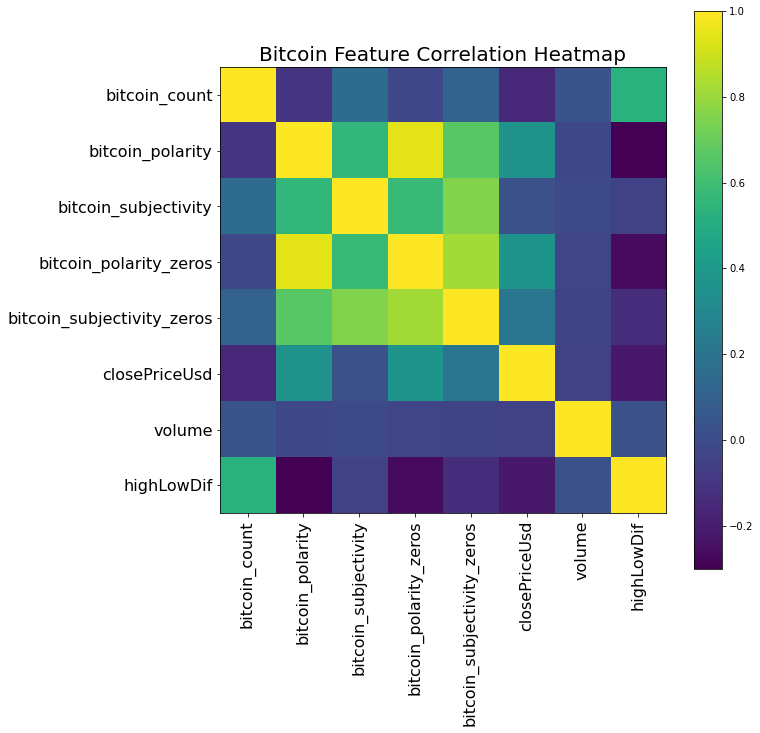

In [23]:
plot_heatmap(bitcoin_df, "Bitcoin", bitcoin_column_names)

- Mild correlation between tweet volume, trade volume and the difference between high and low values
- Correlation between tweet volume and trade volume could come down to the daily periodicty of trading (peak hours for trading may be similar to twitter peak)
- Absolute correlation between marketcap and close price, suggests redundant data (can remove marketetcap)
- looking at close price, there seems to be stronger correlation with polarity than tweet volume (this may be due to the daily periodicity of volume)
- The polarity and subjectivity with zeros deem slightly more correlated with close price (though can run a few models to see if this is so)

## Inspecting Ethereum Data:

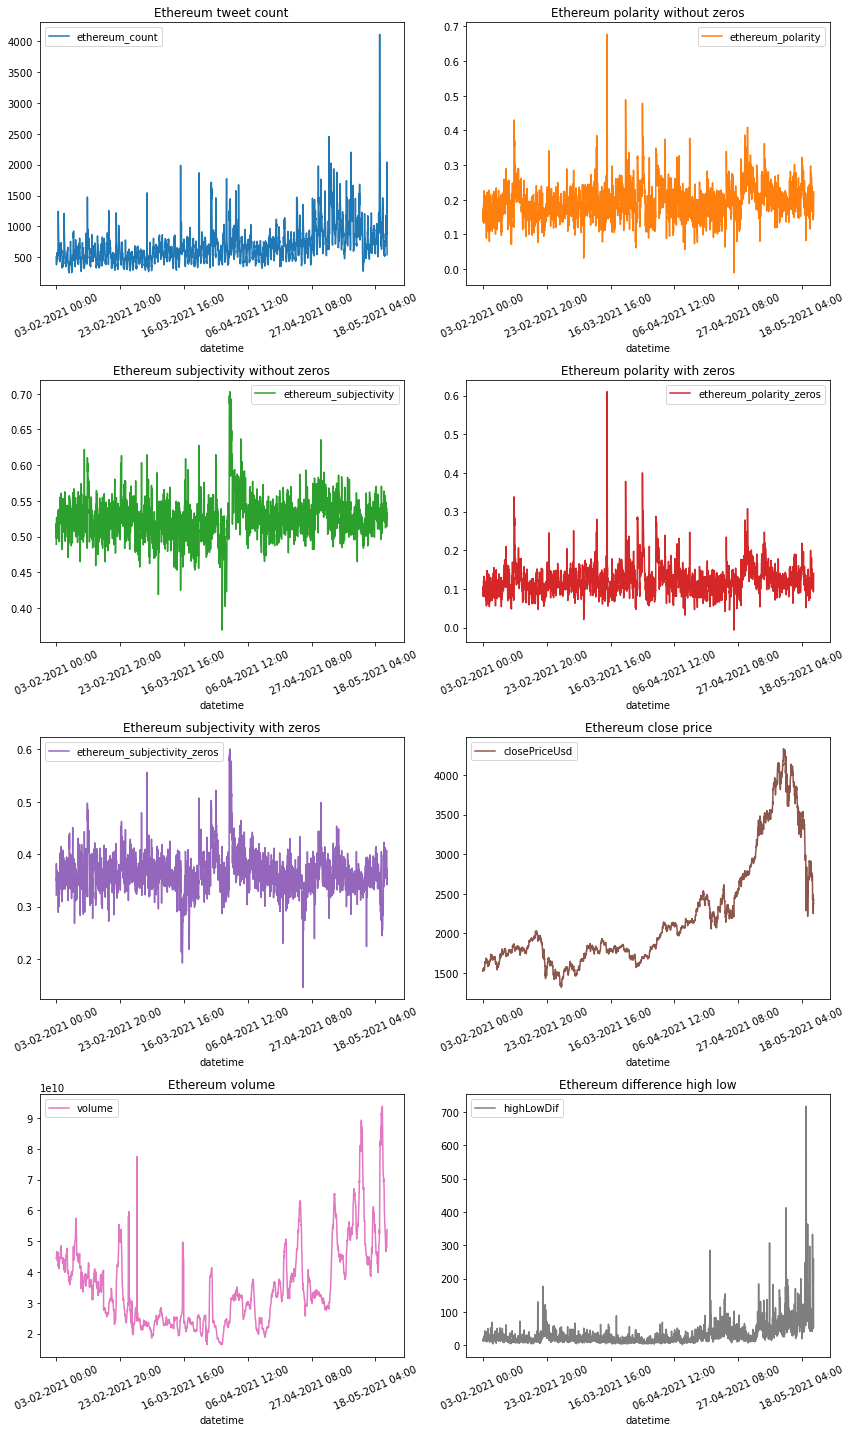

In [24]:
plot_timeseries_features(ethereum_df, ethereum_column_names, time_column, ethereum_titles)

From the plots there do not seem to be any massively anomalous data.

There is an oddly high and sudden spike in polarity, but this is possible, I may look into the tweet files to see if they are caused by spam.

### Printing highest values in each column

To identify any possible anomalous values.

In [25]:
print_largest_each_column(ethereum_df, ethereum_column_names, 10)

--------------------------------------------------------------------------------
ethereum_count
datetime
19-05-2021 13:00    4113
19-05-2021 14:00    2518
03-05-2021 01:00    2457
19-05-2021 15:00    2269
10-05-2021 03:00    2203
19-05-2021 16:00    2128
19-05-2021 12:00    2053
21-05-2021 21:00    2043
03-05-2021 17:00    2027
15-03-2021 14:00    1989
Name: ethereum_count, dtype: int64
--------------------------------------------------------------------------------
ethereum_polarity
datetime
15-03-2021 14:00    0.677289
21-03-2021 14:00    0.488528
27-03-2021 02:00    0.478480
13-02-2021 04:00    0.430239
21-03-2021 15:00    0.422862
13-02-2021 05:00    0.422557
30-04-2021 09:00    0.409321
21-03-2021 16:00    0.404352
29-04-2021 13:00    0.386753
12-03-2021 04:00    0.385497
Name: ethereum_polarity, dtype: float64
--------------------------------------------------------------------------------
ethereum_subjectivity
datetime
31-03-2021 15:00    0.703026
31-03-2021 14:00    0.699721
31

I am content that none of these values seem outside the realm of possibility and none of the spikes seem anomalous enough to disrupt the data.

### Detecting any missing values

In [26]:
print(rows_with_nan_values(ethereum_df))

[1044, 1045]


Missing values were again identified in rows 1044 and 104 in the trade volume column. It is likely that the 'santiment API' servers had an issue at this time or something. The data will be replaced in the same manner as before. 

### Feature heatmap

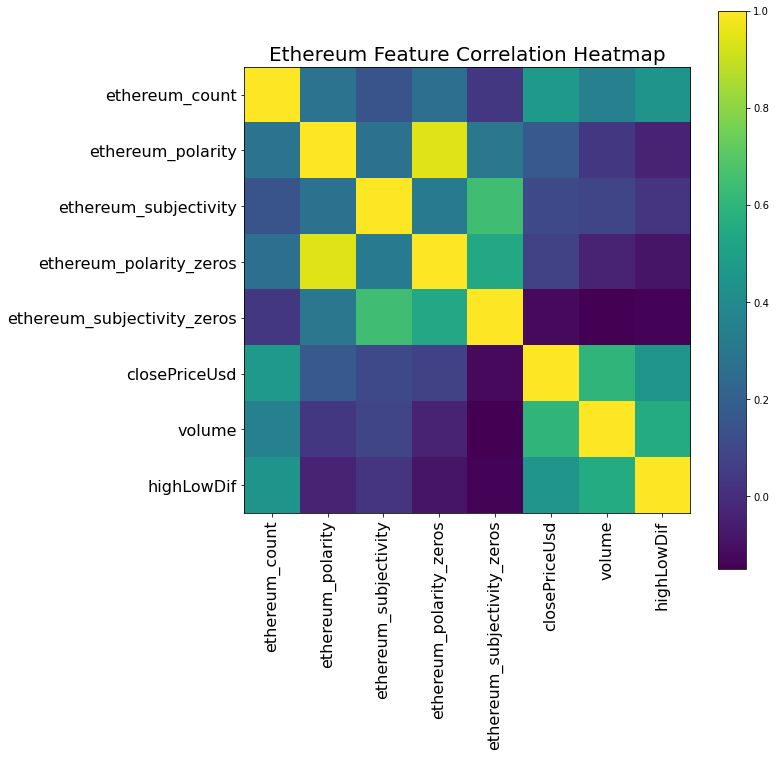

In [27]:
plot_heatmap(ethereum_df, "Ethereum", ethereum_column_names)

## Inspecting Dogecoin Data

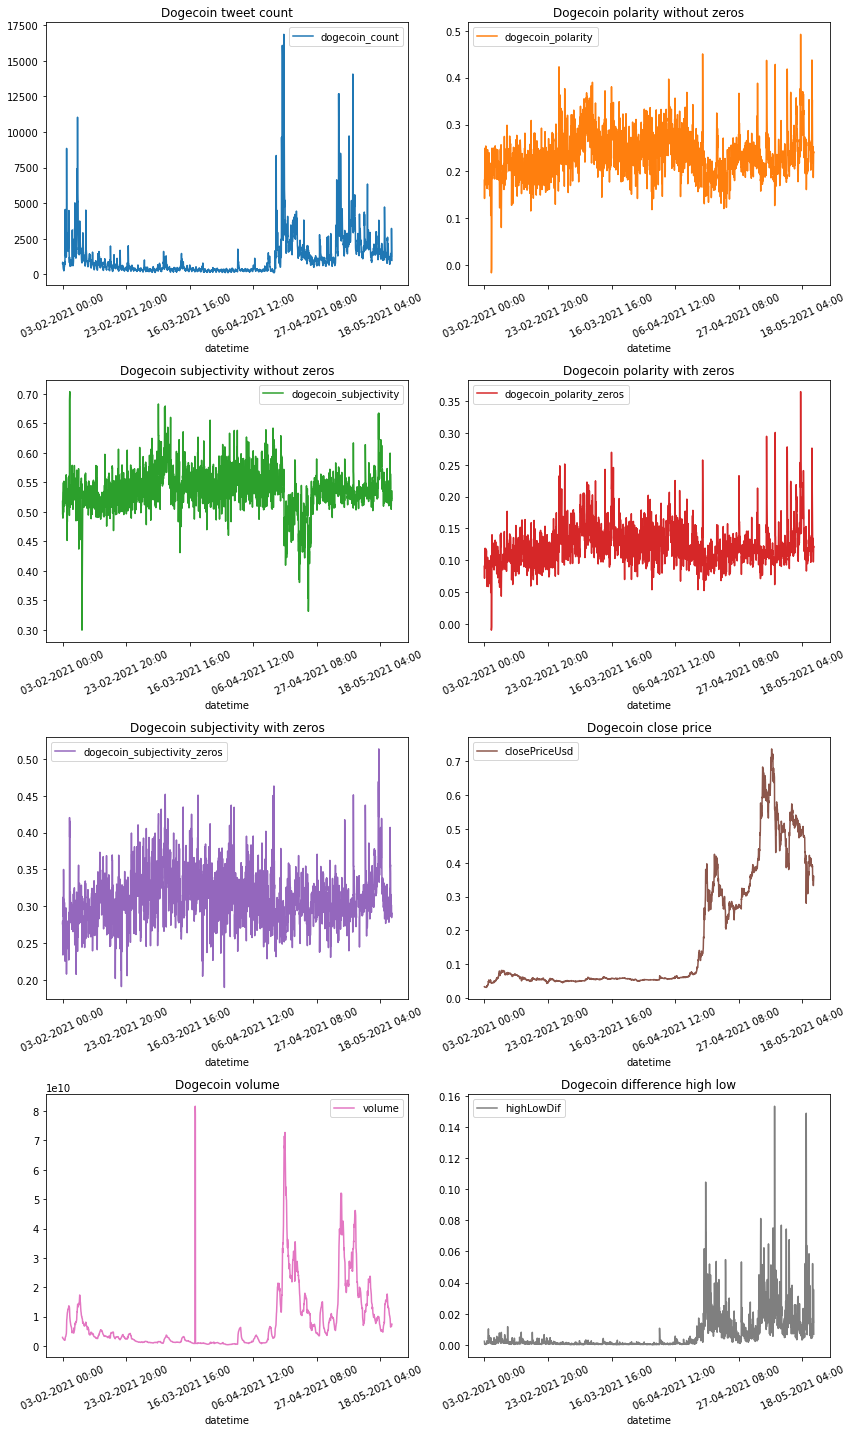

In [28]:
plot_timeseries_features(dogecoin_df, dogecoin_column_names, time_column, dogecoin_titles)

There is a spike in trade volume which seems anomalous for two hours on `18-03-2021` at midday and 1pm. Trade volume seems to naturally reach near the level of this spike later on, however at the time the spike is about 10x the trade volume immediately before and after and there is no evidence of changes in price or volatility.

It could be a real spike caused by very large wallet transfers or something, but I find it unlikely, so the spike will be removed.

### Printing highest values in each column

To identify any possible anomalous values.

In [29]:
print_largest_each_column(dogecoin_df, dogecoin_column_names, 10)

--------------------------------------------------------------------------------
dogecoin_count
datetime
16-04-2021 13:00    16863
16-04-2021 01:00    16086
16-04-2021 02:00    15412
16-04-2021 14:00    14532
09-05-2021 04:00    14071
04-05-2021 14:00    12682
04-05-2021 12:00    12678
16-04-2021 15:00    12084
07-02-2021 22:00    11036
04-05-2021 13:00    10753
Name: dogecoin_count, dtype: int64
--------------------------------------------------------------------------------
dogecoin_polarity
datetime
17-05-2021 16:00    0.492529
15-04-2021 13:00    0.450650
21-05-2021 09:00    0.437745
06-05-2021 12:00    0.436958
09-05-2021 08:00    0.428329
27-02-2021 11:00    0.423147
13-05-2021 06:00    0.418474
13-05-2021 07:00    0.412523
21-05-2021 10:00    0.398123
04-04-2021 10:00    0.396957
Name: dogecoin_polarity, dtype: float64
--------------------------------------------------------------------------------
dogecoin_subjectivity
datetime
05-02-2021 09:00    0.703956
05-02-2021 08:00    0

I am content that the other values seem within normal ranges.

### Detecting any missing values

In [30]:
print(rows_with_nan_values(dogecoin_df))

[]


surprisingly, dogecoin does not seem to have the same two missing data points as bitcoin and ehtereum.

### Feature heatmap

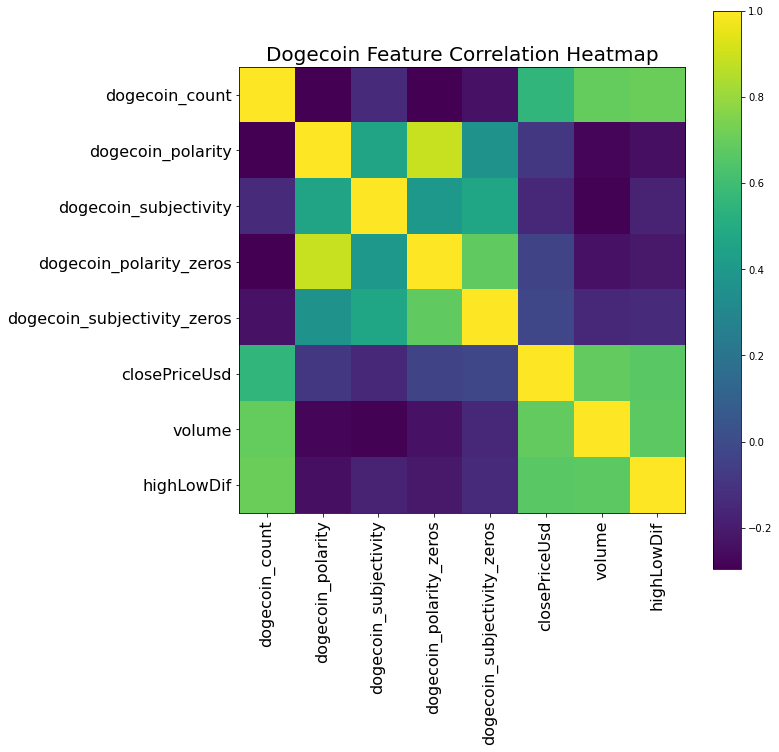

In [33]:
plot_heatmap(dogecoin_df, "Dogecoin", dogecoin_column_names)